## Predicting the Sale Price of Bulldozers

In this notebook, we're going through a machine learning project with the goal of predicting the sale price of bulldozers.

## 1. Problem Definition

Predict the future sale price of a bulldozer, given previous examples of how much a smilar bulldozer had been sold for?

## 2. Data

We are using Blue Book for Bulldozers dataset from kaggle: https://www.kaggle.com/c/bluebook-for-bulldozers/data

The data for this project is split into three parts:

- Train.csv is the training set, which contains data through the end of 2011.
- Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012.
- Test.csv is the test set, which contains data from May 1, 2012 - November 2012.

## 3. Evaluation

The goal for most of the regression problems is to minimize error. For example, our goal for this project is to build a machine learning model which minimize **RMSLE(Root Mean Square Log Error)**.

## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [2]:
# import training and validation data
df = pd.read_csv("/content/drive/MyDrive/Bulldozer Price/Dataset/TrainAndValid.csv", low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

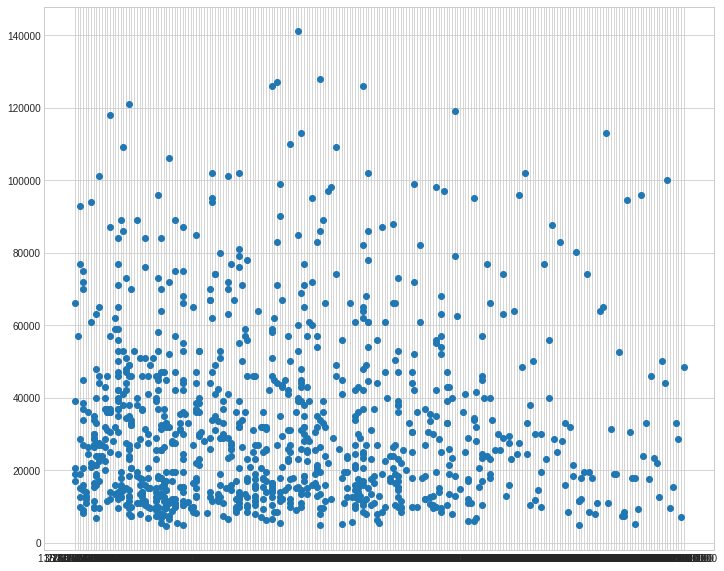

In [3]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

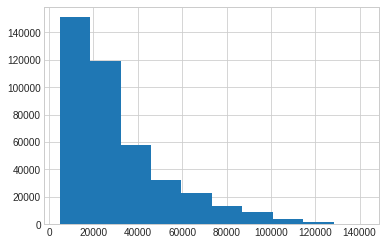

In [4]:
df.SalePrice.hist();

In [5]:
df.saledate[:10]

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
5    12/18/2008 0:00
6     8/26/2004 0:00
7    11/17/2005 0:00
8     8/27/2009 0:00
9      8/9/2007 0:00
Name: saledate, dtype: object

In [6]:
df.saledate.dtype

dtype('O')

#### Parsing Dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of which of our columns have dates in it using `parse_dates` parameter.

In [7]:
# Covert dates to date dtype
df = pd.read_csv("/content/drive/MyDrive/Bulldozer Price/Dataset/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

In [8]:
df.saledate.dtype

dtype('<M8[ns]')

In [9]:
df.saledate[:10]

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
5   2008-12-18
6   2004-08-26
7   2005-11-17
8   2009-08-27
9   2007-08-09
Name: saledate, dtype: datetime64[ns]

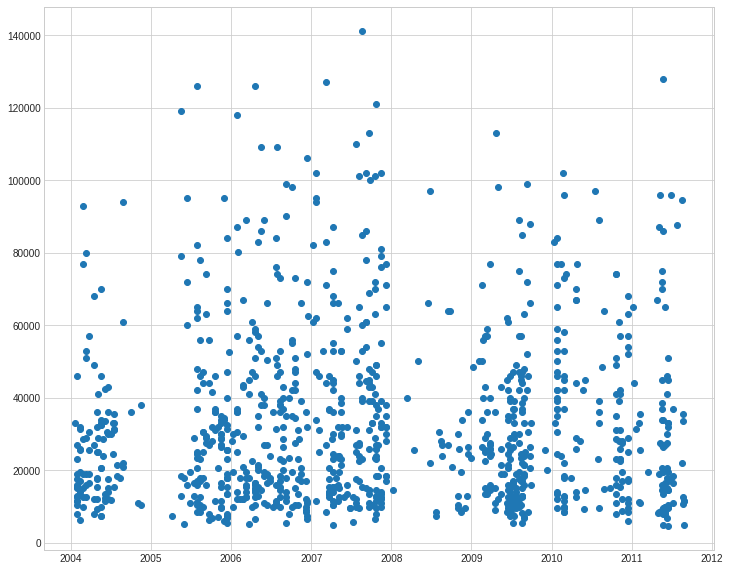

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);

In [11]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Sort dataframe by date

When working with time-series data, it's a good idea to sort the data by date.

In [12]:
df.sort_values(by=["saledate"], ascending=True, inplace=True)

In [13]:
df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [14]:
# Make a backup copy of the dataframe
df_tmp = df.copy()

## Feature Engineering

In [15]:
df[:1].saledate

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [16]:
df[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int64

In [17]:
df[:1].saledate.dt.day

205615    17
Name: saledate, dtype: int64

#### Add datetime parameters for `saledate` column

In [18]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [19]:
# As we have enriched our DataFrame with datetime features, we can remove saledate column
df_tmp.drop("saledate", axis=1, inplace=True)

### Turning data into numbers

One way we can turn all of our data into numbers is by converting them into padas `category`

In [20]:
# Find the columns that has dtype string

# label is the label name, content is the contents of that label
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    df_tmp[label] = content.astype("category").cat.as_ordered() # convert string dtypes into category dtype

### Dealing with missing values

In [21]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

**Fill Missing Numeric Values**

In [22]:
# Check which columns have null values that have numeric dtype
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

auctioneerID
MachineHoursCurrentMeter


In [23]:
# Fill missing values with median value
for label, content in df_tmp.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      df_tmp[label] = content.fillna(content.median())

**Filling Missing Pandas Category type Values**

In [24]:
for label, content in df_tmp.items():
  # as the columns that are not numeric will be of pandas category type
  if not pd.api.types.is_numeric_dtype(content):
    # Turn categories into numbers
    df_tmp[label] = pd.Categorical(content).codes+1 # by default pd category set a code of -1 for missing values, that's why we added 1 to make it 0.

In [25]:
df_tmp.isna().sum()

SalesID                     0
SalePrice                   0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper    

No more missing values are there in our dataframe.

Besides, all of our data are now numeric.

So, we can fit machine learning models now.

## Let's start Model Driven EDA

In [26]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, random_state=42) # use all the cores of processor, set random seed to 42

In [27]:
%%time

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

CPU times: user 16min 26s, sys: 4.46 s, total: 16min 31s
Wall time: 8min 26s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [39]:
# # Save the model
# from joblib import dump, load

# dump(model, filename="price_model_1.joblib")

In [40]:
# Score
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.8596954864312933

But this above metric isn't much reliable because, we are testing on the exact same dataset that we used to train the model.

### Split data into train/validation set

In [41]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

In [42]:
len(df_train), len(df_val)

(401125, 11573)

In [43]:
# Split into X/y

X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_val, y_val = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

In [44]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 56), (401125,), (11573, 56), (11573,))

### Building Evaluation Functions

In [45]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Calculate Root Mean Squared Log Error (RMSLE)
def rmsle(y_test, y_preds):
  # Square root of mean squared log error
  return np.sqrt(mean_squared_log_error(y_test, y_preds))


# Evaluate different metrics
def show_scores(model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_val)

  scores = {
            "Training MAE": mean_absolute_error(y_train, train_preds),
            "Valid MAE": mean_absolute_error(y_val, val_preds),
            "Training RMSLE": rmsle(y_train, train_preds),
            "Valid RMSLE": rmsle(y_val, val_preds),
            "Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_val, val_preds)
           }

  return scores

### Test the data on a subset to tune hyperparameters

In [46]:
len(X_train)

401125

In [47]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, random_state=42, max_samples=10000)

In [48]:
%%time

model.fit(X_train, y_train)

CPU times: user 32 s, sys: 129 ms, total: 32.2 s
Wall time: 16.7 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [49]:
show_scores(model)

{'Training MAE': 5563.72867258336,
 'Training RMSLE': 0.2578202020674087,
 'Training R^2': 0.8605936890077203,
 'Valid MAE': 7168.9377352458305,
 'Valid RMSLE': 0.2929702627803096,
 'Valid R^2': 0.8322757239076886}

### Hyperparameter tuning with RandomizedSearchCV

In [50]:
%%time

from sklearn.model_selection import RandomizedSearchCV

rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "auto"],
    "max_samples": [10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42), param_distributions=rf_grid, n_iter=2, cv=5, verbose=True)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.7s finished


CPU times: user 6.74 s, sys: 827 ms, total: 7.57 s
Wall time: 31 s


In [51]:
rs_model.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'max_samples': 10000,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 10}

In [52]:
show_scores(rs_model)

{'Training MAE': 6695.643384862238,
 'Training RMSLE': 0.2991697235462587,
 'Training R^2': 0.8041997891139298,
 'Valid MAE': 8177.286069878996,
 'Valid RMSLE': 0.3253976691082237,
 'Valid R^2': 0.7797901019303817}

### Train the model with the best hyperparameters

These hyperparameters were found after 100 iterations of RandomizedSearchCV

In [53]:
%%time

ideal_model = RandomForestRegressor(n_jobs=-1, random_state=42, n_estimators=40, min_samples_leaf=1, min_samples_split=14, max_features=0.5, max_samples=None)

ideal_model.fit(X_train, y_train)

CPU times: user 3min 1s, sys: 251 ms, total: 3min 1s
Wall time: 1min 32s


In [54]:
show_scores(ideal_model)

{'Training MAE': 2942.3406510781565,
 'Training RMSLE': 0.144153608169812,
 'Training R^2': 0.9591796499547254,
 'Valid MAE': 5963.47989565748,
 'Valid RMSLE': 0.24694437453455995,
 'Valid R^2': 0.8813934466550004}

## Make Predictions on Test Data

Test dataframe must be in the exact same form as the training and validation dataframe

In [55]:
df_test = pd.read_csv("/content/drive/MyDrive/Bulldozer Price/Dataset/Test.csv", parse_dates=["saledate"], low_memory=False)

In [63]:
def preprocess_data(df):
  df["saleYear"] = df.saledate.dt.year
  df["saleMonth"] = df.saledate.dt.month
  df["saleDay"] = df.saledate.dt.day
  df["saleDayOfWeek"] = df.saledate.dt.dayofweek
  df["saleDayOfYear"] = df.saledate.dt.dayofyear

  df.sort_values(by=["saledate"], ascending=True, inplace=True)

  df.drop("saledate", axis=1, inplace=True)

  # Find the columns that has dtype string

  # label is the label name, content is the contents of that label
  for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
      df[label] = content.astype("category").cat.as_ordered() # convert string dtypes into category dtype

  # Fill missing values with median value
  for label, content in df.items():
    if pd.api.types.is_numeric_dtype(content):
      if pd.isnull(content).sum():
        df[label] = content.fillna(content.median())

  for label, content in df.items():
    # as the columns that are not numeric will be of pandas category type
    if not pd.api.types.is_numeric_dtype(content):
      # Turn categories into numbers
      df[label] = pd.Categorical(content).codes+1

  return df

In [64]:
df_test = preprocess_data(df_test)

In [66]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)

In [67]:
len(test_preds)

12457

In [68]:
test_preds

array([10013.24359795, 19204.05231274, 23832.71657335, ...,
       47706.41938418, 45773.18682996, 33899.42595578])

But our prediction output is not in the form that Kaggle has asked for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [69]:
df_preds = pd.DataFrame()

df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds

df_preds

,SalesID,SalePrice
1408,4317459,10013.243598
1023,4249784,19204.052313
1728,4392603,23832.716573
1167,4274831,26034.006472
1594,4362801,11749.617427
...,...,...
9941,6620191,8286.822992
9936,6620142,12682.659372
11620,6635116,47706.419384
9995,6621460,45773.186830


In [70]:
# Export predictions data
df_preds.to_csv("/content/drive/MyDrive/Bulldozer Price/test_predictions.csv", index=False)

## Feature Importance

Seek to find out which different attributes of the data were most important when it comes to predicting the target variable.

In [73]:
def plot_features(columns, importances, n=20):
  df = (pd.DataFrame({
      "features": columns,
      "feature_importances": importances
  }).sort_values("feature_importances", ascending=False).reset_index(drop=True))

  fig, ax = plt.subplots(figsize=(12, 10))
  ax.barh(df["features"][:n], df["feature_importances"][:20])

  ax.set_xlabel("Feature Importance")
  ax.set_ylabel("Features")

  ax.invert_yaxis()

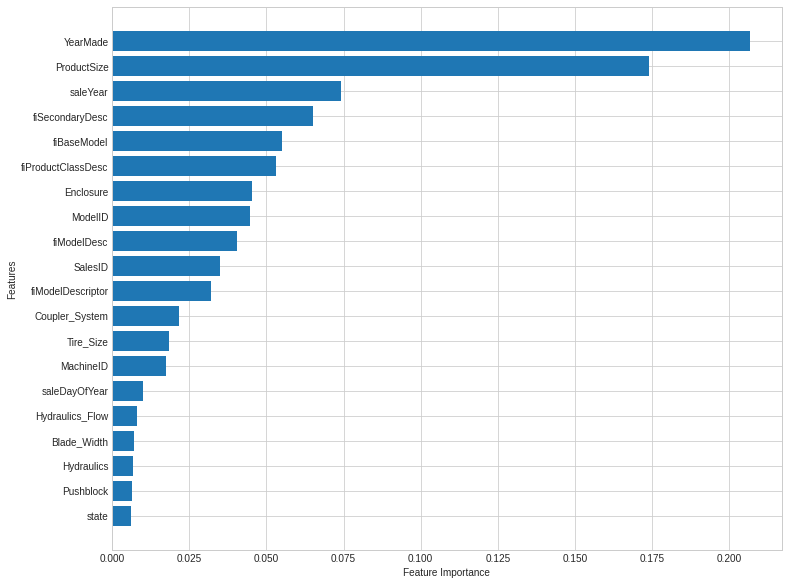

In [74]:
plot_features(X_train.columns, ideal_model.feature_importances_)

---